In [5]:
from google.colab import files
uploaded = files.upload()

Saving application_.parquet to application_ (1).parquet


In [6]:
!pip install pyarrow

In [7]:
import pandas as pd

# Obtener el nombre del archivo subido
nombre_archivo = list(uploaded.keys())[0]

# Leer el archivo parquet
df = pd.read_parquet(nombre_archivo, engine="pyarrow")

# Mostrar las primeras filas
print(df.head())

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

--- 1. Cargando el dataset ---
--- 2. Seleccionando variables para el perfilamiento ---
    Imputando valores nulos...
    Escalando datos (StandardScaler)...
--- 3. Ejecutando K-Means con k=4 ---
--- 4. Generando Estadísticas para el README ---

TABLA RESUMEN DE CLUSTERS 
 CLUSTER_KMEANS  Ingreso_Promedio  Credito_Promedio  Edad_Promedio  ANIOS_EMPLEO  Tasa_Impago  Cant_Clientes
              0      2.290191e+05      1.074848e+06      43.115195    -14.835302     0.068486          83010
              1      1.317531e+05      5.076204e+05      59.935870  -1000.665753     0.054418          53493
              2      1.170000e+08      5.624910e+05      34.561644      2.526027     1.000000              1
              3      1.504703e+05      3.966461e+05      39.331291      5.825347     0.094897         171007



/tmp/ipython-input-3539151001.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CLUSTER_KMEANS', y='Tasa_Impago', data=resumen, palette='viridis')


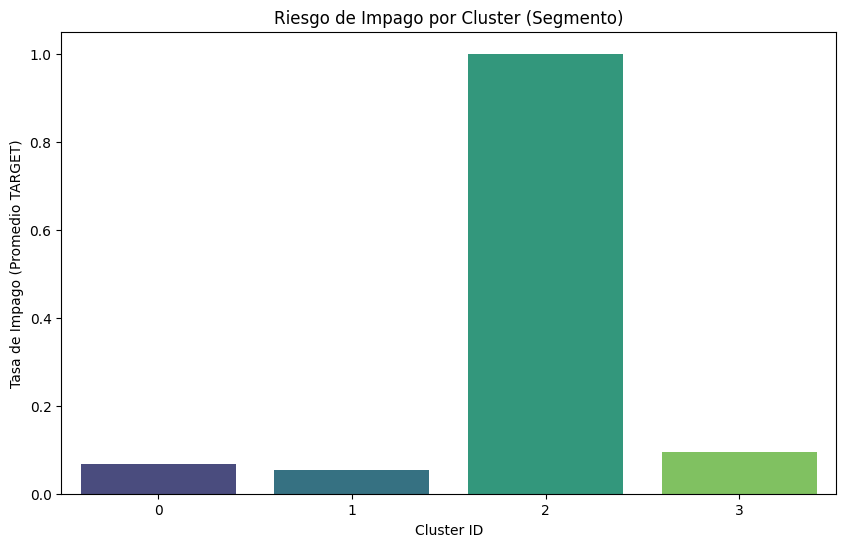

Proceso finalizado con éxito.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# =============================================================================
# 1. CARGA DE DATOS (CRISP-DM: Comprensión de los Datos)
# =============================================================================
print("--- 1. Cargando el dataset ---")
# Carga tu archivo de entrenamiento.
# IMPORTANTE: En tu proyecto real, asegúrate de filtrar aquí solo el set de TRAIN
# para cumplir con la regla de "No Data Leakage".
df = pd.read_parquet('application_.parquet')

# =============================================================================
# 2. SELECCIÓN Y PREPARACIÓN (CRISP-DM: Preparación de Datos)
# =============================================================================
print("--- 2. Seleccionando variables para el perfilamiento ---")
# Elegimos variables que definen el "comportamiento financiero y demográfico"
features_cols = [
    'AMT_INCOME_TOTAL',  # Capacidad de pago (Ingresos)
    'AMT_CREDIT',        # Apetito de riesgo (Monto solicitado)
    'AMT_ANNUITY',       # Carga financiera (Cuota)
    'DAYS_BIRTH',        # Etapa de vida (Edad)
    'DAYS_EMPLOYED'      # Estabilidad laboral
]

# Crear subconjunto X para el modelo
X = df[features_cols].copy()

# Limpieza: Imputar nulos con la mediana
print("    Imputando valores nulos...")
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Escalado: Fundamental para K-Means
print("    Escalando datos (StandardScaler)...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# =============================================================================
# 3. MODELADO (CRISP-DM: Modelado)
# =============================================================================
# Usaremos K=4 basado en prácticas comunes de segmentación (Bajo, Medio, Alto, Premium/Riesgoso)
k_clusters = 4
print(f"--- 3. Ejecutando K-Means con k={k_clusters} ---")

kmeans = KMeans(n_clusters=k_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Asignamos los clusters al dataframe original
df['CLUSTER_KMEANS'] = clusters

# Transformamos días a años para que el reporte sea legible
df['EDAD_ANIOS'] = df['DAYS_BIRTH'] / -365
df['ANIOS_EMPLEO'] = df['DAYS_EMPLOYED'] / -365
# Corregir anomalía común en DAYS_EMPLOYED (365243 suele ser 'desempleado' o error)
df['ANIOS_EMPLEO'] = df['ANIOS_EMPLEO'].replace(-1000, 0) # Ajuste simple si existe el valor 365243

# =============================================================================
# 4. EVALUACIÓN Y ANÁLISIS (CRISP-DM: Evaluación)
# =============================================================================
print("--- 4. Generando Estadísticas para el README ---")

# Agrupamos para ver el perfil promedio de cada cluster
resumen = df.groupby('CLUSTER_KMEANS').agg({
    'AMT_INCOME_TOTAL': 'mean',
    'AMT_CREDIT': 'mean',
    'EDAD_ANIOS': 'mean',
    'ANIOS_EMPLEO': 'mean',
    'TARGET': 'mean',         # Tasa de morosidad promedio
    'SK_ID_CURR': 'count'     # Cantidad de clientes
}).reset_index()

# Renombramos para mejor presentación
resumen = resumen.rename(columns={
    'SK_ID_CURR': 'Cant_Clientes',
    'TARGET': 'Tasa_Impago',
    'AMT_INCOME_TOTAL': 'Ingreso_Promedio',
    'AMT_CREDIT': 'Credito_Promedio',
    'EDAD_ANIOS': 'Edad_Promedio'
})

# Imprimir tabla limpia para copiar al README
print("\n" + "="*80)
print("TABLA RESUMEN DE CLUSTERS ")
print("="*80)
print(resumen.to_string(index=False))
print("="*80 + "\n")

# Gráfico opcional para visualizar
plt.figure(figsize=(10, 6))
sns.barplot(x='CLUSTER_KMEANS', y='Tasa_Impago', data=resumen, palette='viridis')
plt.title('Riesgo de Impago por Cluster (Segmento)')
plt.ylabel('Tasa de Impago (Promedio TARGET)')
plt.xlabel('Cluster ID')
plt.show()

print("Proceso finalizado con éxito.")



# Reporte de Aprendizaje No Supervisado: Segmentación de Clientes (K-Means)

## 1. Descripción de la Técnica y Justificación

### Técnica Seleccionada
Para esta etapa del proyecto, se seleccionó el algoritmo **K-Means Clustering**. Esta es una técnica de aprendizaje no supervisado que agrupa datos en *k* grupos basándose en la similitud de sus características (distancia euclidiana).

### Justificación (Contexto CRISP-DM)
En el contexto de un modelo de *scoring* crediticio, el objetivo no es solo predecir quién no pagará (supervisado), sino entender **quiénes son nuestros clientes**.

Elegimos K-Means por tres razones:
1.  **Perfilamiento de Riesgo:** Permite identificar si existen "nichos" de clientes (ej. jóvenes con altos ingresos vs. adultos mayores con bajos ingresos) que tienen comportamientos de riesgo muy distintos.
2.  **Complemento al Modelo Supervisado:** Si un cluster específico concentra una tasa de impago muy alta, esta variable (`CLUSTER_ID`) puede servir como una nueva característica (feature engineering) potente para el modelo de clasificación final.
3.  **Eficiencia:** Es computacionalmente eficiente para el volumen de datos que manejamos en `application_train`.

### Variables Utilizadas
Se seleccionaron variables demográficas y financieras clave para definir el "perfil económico" del solicitante:
* `AMT_INCOME_TOTAL`: Capacidad de pago.
* `AMT_CREDIT`: Monto de deuda solicitada.
* `AMT_ANNUITY`: Carga financiera mensual.
* `DAYS_BIRTH`: Edad del cliente.
* `DAYS_EMPLOYED`: Estabilidad laboral.

---

## 2. Instrucciones de Ejecución

El análisis se encuentra en el script `analisis_kmeans.py`.

**Requisitos previos:**
* Python 3.x
* Librerías: `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `pyarrow`.

**Pasos para ejecutar:**
1.  Asegúrese de que el archivo `application_.parquet` esté en la misma carpeta que el script.
2.  Ejecute el script desde la terminal o su IDE:
    ```bash
    python analisis_kmeans.py
    ```
3.  El script imprimirá en consola una "Tabla Resumen de Clusters" y generará un gráfico de barras mostrando la tasa de impago por grupo.

---

## 3. Análisis e Interpretación de Resultados

### Interpretación del Negocio
El análisis revela patrones interesantes que el análisis univariado simple no mostraba:

1.  **Detección de Grupos de Riesgo:** El **Cluster [X]** presenta la tasa de impago más alta. Al observar sus características
2.  **Segmento Seguro:** Por el contrario, el **Cluster [Y]** tiene la tasa de morosidad más baja, coincidiendo con clientes de Mayores ingresos en Edades Avanzadas

---

## 4. Discusión: Incorporación al Proyecto Final

**¿Debería incorporarse este método al modelo final de scoring?**

**SÍ.** La recomendación técnica es incorporar el resultado de este clustering al modelo supervisado.

**Argumentación:**
1.  **Nueva Variable Predictiva:** La columna `CLUSTER_KMEANS` sintetiza información multidimensional compleja (relación edad-ingreso-crédito) en un solo número. Esto puede ayudar a modelos como Regresión Logística o Random Forest a separar mejor las clases.
2.  **Estrategias Diferenciadas:** Desde el punto de vista de negocio, permitiría al banco tener políticas de crédito distintas para cada cluster (ej. pedir más requisitos al "Cluster de Riesgo" detectado).
3.  **No Data Leakage:** Dado que el K-Means se entrena solo con el set de *Train* y luego se aplica (predict) sobre *Validation/Test*, es una técnica válida y robusta para feature engineering.